In [20]:
from gurobipy import *
from gurobipy import GRB
import math

In [21]:
m = Model("Modelo Proyecto")

In [19]:
# Datos 14 nodos

edges = [
    [14, 13, 7.50, 10.00],
    [13, 12, 8.00, 11.00],
    [13, 11, 9.00, 18.00],
    [11, 10, 4.00, 4.00],
    [14, 9, 11.00, 11.00],
    [9, 8, 8.00, 11.00],
    [9, 7, 11.00, 11.00],
    [8, 6, 11.00, 11.00],
    [8, 5, 8.00, 11.00],
    [14, 4, 11.00, 11.00],
    [4, 3, 9.00, 12.00],
    [4, 2, 8.00, 11.00],
    [2, 1, 4.00, 4.00],
    [12, 6, 4.00, 4.00],
    [7, 3, 4.00, 4.00],
    [10, 1, 9.00, 12.00]
]

nodes = [
    [14, 0.0, 0.0, 0.0],
    [13, 2000.0, 1600.0, 0.0],
    [12, 3000.0, 1500.0, 1100.0],
    [11, 2000.0, 800.0, 1200.0],
    [10, 1500.0, 1200.0, 0.0],
    [9, 4000.0, 2700.0, 0.0],
    [8, 5000.0, 3000.0, 1200.0],
    [7, 1000.0, 900.0, 0.0],
    [6, 600.0, 100.0, 600.0],
    [5, 4500.0, 2000.0, 3700.0],
    [4, 1000.0, 900.0, 0.0],
    [3, 1000.0, 700.0, 1800.0],
    [2, 1000.0, 900.0, 0.0],
    [1, 2100.0, 1000.0, 1800.0]
]

# Sets

N = [node[0] for node in nodes]
E = [(edge[0], edge[1]) for edge in edges]


# Parametros

nref = 14
vref = 1
vbase = 23
sbase = 100000
tol = 10**-8
vmin = 0.93
vmax = 1.05
zbase = 100

R = {(edge[0], edge[1]): edge[2]/100 for edge in edges}
X = {(edge[0], edge[1]): edge[3]/100 for edge in edges}
Z = {(edge[0], edge[1]): (edge[2]/100)**2 + (edge[3]/100)**2 for edge in edges}
minV = vmin
maxV = vmax

# Falta por saber
Imax = {(edge[0], edge[1]): 100 for edge in edges}

Pd = {node[0]: node[1]/sbase for node in nodes}
Qd = {node[0]: node[2]/sbase for node in nodes}
Qbc = {node[0]: node[3]/sbase for node in nodes}
deltaS = {}
deltaV = {}
mS = 0
n = len(N)
s = 5
w = 5

b = 100

In [23]:
# Datos 33 nodos

edges = [
    [1, 2, 0.0922, 0.0470],
    [2, 3, 0.4930, 0.2511],
    [3, 4, 0.3660, 0.1864],
    [4, 5, 0.3811, 0.1941],
    [5, 6, 0.8190, 0.7070],
    [6, 7, 0.1872, 0.6188],
    [7, 8, 0.7114, 0.2351],
    [8, 9, 1.0300, 0.7400],
    [9, 10, 1.0440, 0.7400],
    [10, 11, 0.1966, 0.0650],
    [11, 12, 0.3744, 0.1238],
    [12, 13, 1.4680, 1.1550],
    [13, 14, 0.5416, 0.7129],
    [14, 15, 0.5910, 0.5260],
    [15, 16, 0.7463, 0.5450],
    [16, 17, 1.2890, 1.7210],
    [17, 18, 0.7320, 0.5740],
    [2, 19, 0.1640, 0.1565],
    [19, 20, 1.5042, 1.3554],
    [20, 21, 0.4095, 0.4784],
    [21, 22, 0.7089, 0.9373],
    [3, 23, 0.4512, 0.3083],
    [23, 24, 0.8980, 0.7091],
    [24, 25, 0.8960, 0.7011],
    [6, 26, 0.2030, 0.1034],
    [26, 27, 0.2842, 0.1447],
    [27, 28, 1.0590, 0.9337],
    [28, 29, 0.8042, 0.7006],
    [29, 30, 0.5075, 0.2585],
    [30, 31, 0.9744, 0.9630],
    [31, 32, 0.3105, 0.3619],
    [32, 33, 0.3410, 0.5302],
    [8, 21, 2.0000, 2.0000],
    [9, 15, 2.0000, 2.0000],
    [12, 22, 2.0000, 2.0000],
    [18, 33, 0.5000, 0.5000],
    [25, 29, 0.5000, 0.5000]
]


nodes = [
    [1, 0, 0, 0.00],
    [2, 100, 60, 0.00],
    [3, 90, 40, 0.00],
    [4, 120, 80, 0.00],
    [5, 60, 30, 0.00],
    [6, 60, 20, 0.00],
    [7, 200, 100, 0.00],
    [8, 200, 100, 0.00],
    [9, 60, 20, 0.00],
    [10, 60, 20, 0.00],
    [11, 45, 30, 0.00],
    [12, 60, 35, 0.00],
    [13, 60, 35, 0.00],
    [14, 120, 80, 0.00],
    [15, 60, 10, 0.00],
    [16, 60, 20, 0.00],
    [17, 60, 20, 0.00],
    [18, 90, 40, 0.00],
    [19, 90, 40, 0.00],
    [20, 90, 40, 0.00],
    [21, 90, 40, 0.00],
    [22, 90, 40, 0.00],
    [23, 90, 50, 0.00],
    [24, 420, 200, 0.00],
    [25, 420, 200, 0.00],
    [26, 60, 25, 0.00],
    [27, 60, 25, 0.00],
    [28, 60, 20, 0.00],
    [29, 120, 70, 0.00],
    [30, 200, 600, 0.00],
    [31, 150, 70, 0.00],
    [32, 210, 100, 0.00],
    [33, 60, 40, 0.00]
]


# Sets

N = [node[0] for node in nodes]
E = [(edge[0], edge[1]) for edge in edges]


# Parametros

nref = 1
vref = 1
vbase = 12.66
sbase = 1000
tol = 10**-8
vmin = 0.93
vmax = 1.05
zbase = 1000*((vbase**2)/sbase)

R = {(edge[0], edge[1]): edge[2]/zbase for edge in edges}
X = {(edge[0], edge[1]): edge[3]/zbase for edge in edges}
Z = {(edge[0], edge[1]): (edge[2]/zbase)**2 + (edge[3]/zbase)**2 for edge in edges}
minV = vmin
maxV = vmax

# Falta por saber
Imax = {(edge[0], edge[1]): 100 for edge in edges}

Pd = {node[0]: node[1]/sbase for node in nodes}
Qd = {node[0]: node[2]/sbase for node in nodes}
Qbc = {node[0]: node[3]/sbase for node in nodes}
deltaS = {}
deltaV = {}
mS = 0
n = len(N)
s = 5
w = 5

b = 100

In [24]:
# Variables Proyecto

Pg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Pg")
Qg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Qg")
P = m.addVars(E, vtype=GRB.CONTINUOUS, name="P")
Q = m.addVars(E, vtype=GRB.CONTINUOUS, name="Q")
V = m.addVars(N, vtype=GRB.CONTINUOUS, name="V")
I = m.addVars(E, vtype=GRB.CONTINUOUS, name="I")
deltaV = m.addVars(E, vtype=GRB.CONTINUOUS, lb=float('-inf'), name="deltaV")
y = m.addVars(E, vtype=GRB.BINARY, name="y")

In [25]:
# Funcion objetivo

m.setObjective(quicksum(R[edge] * I[edge] for edge in E), GRB.MINIMIZE)

In [26]:
# Restricciones Proyecto
for node in N:
    m.addConstr(quicksum(P[edge] for edge in E if edge[1] == node) - quicksum(P[edge] + R[edge]*I[edge] for edge in E if edge[0] == node) + Pg[node] == Pd[node])
    m.addConstr(quicksum(Q[edge] for edge in E if edge[1] == node) - quicksum(Q[edge] + X[edge]*I[edge] for edge in E if edge[0] == node) + Qg[node] == Qd[node])

for edge in E:
    m.addConstr(V[edge[0]] == V[edge[1]] + 2*(R[edge]*P[edge] + X[edge]*Q[edge]) + Z[edge]*I[edge] + deltaV[edge])
    m.addConstr(-b*(1-y[edge]) <= deltaV[edge])
    m.addConstr(deltaV[edge] <= b*(1-y[edge]))
    m.addConstr(V[edge[0]]*I[edge] == P[edge]**2 + Q[edge]**2)
    m.addConstr(P[edge] <= maxV*Imax[edge]*y[edge])
    m.addConstr(Q[edge] <= maxV*Imax[edge]*y[edge])
    m.addConstr(V[edge[0]]*I[edge] == P[edge]**2 + Q[edge]**2)

for node in N:
    m.addConstr(minV**2 <= V[node])
    m.addConstr(V[node] <= maxV**2)
    m.addConstr(I[edge] <= (Imax[edge]**2)*y[edge])
    
m.addConstr(quicksum(y[edge] for edge in E) == n - 1)

for node in N:
    if node != nref:
        m.addConstr(Pg[node] == 0)
        m.addConstr(Qg[node] == 0)        

In [27]:
m.setParam(GRB.Param.NonConvex, 2)
m.setParam(GRB.Param.FeasibilityTol, tol)
m.optimize()

Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-08
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [10]:
m.display()

Minimize
0.075 I[14,13] + 0.08 I[13,12] + 0.09 I[13,11] + 0.04 I[11,10] + 0.11 I[14,9]
+ 0.08 I[9,8] + 0.11 I[9,7] + 0.11 I[8,6] + 0.08 I[8,5] + 0.11 I[14,4] + 0.09 I[4,3]
+ 0.08 I[4,2] + 0.04 I[2,1] + 0.04 I[12,6] + 0.04 I[7,3] + 0.09 I[10,1]
Subject To
R0: Pg[14] + -1.0 P[14,13] + -1.0 P[14,9] + -1.0 P[14,4] + -0.075 I[14,13] + -0.11
 I[14,9] + -0.11 I[14,4] = 0
R1: Qg[14] + -1.0 Q[14,13] + -1.0 Q[14,9] + -1.0 Q[14,4] + -0.1 I[14,13] + -0.11
 I[14,9] + -0.11 I[14,4] = 0
R2: Pg[13] + P[14,13] + -1.0 P[13,12] + -1.0 P[13,11] + -0.08 I[13,12] + -0.09 I[13,11]
 = 0.02
R3: Qg[13] + Q[14,13] + -1.0 Q[13,12] + -1.0 Q[13,11] + -0.11 I[13,12] + -0.18 I[13,11]
 = 0.016
  R4: Pg[12] + P[13,12] + -1.0 P[12,6] + -0.04 I[12,6] = 0.03
  R5: Qg[12] + Q[13,12] + -1.0 Q[12,6] + -0.04 I[12,6] = 0.015
  R6: Pg[11] + P[13,11] + -1.0 P[11,10] + -0.04 I[11,10] = 0.02
  R7: Qg[11] + Q[13,11] + -1.0 Q[11,10] + -0.04 I[11,10] = 0.008
  R8: Pg[10] + P[11,10] + -1.0 P[10,1] + -0.09 I[10,1] = 0.015
  R9: Qg[10] 

  : 0.0 + [ -1.0 P[14,13] ^ 2 + -1.0 Q[14,13] ^ 2 + V[14] * I[14,13] ] >= 0
  : 0.0 + [ -1.0 P[13,12] ^ 2 + -1.0 Q[13,12] ^ 2 + V[13] * I[13,12] ] >= 0
  : 0.0 + [ -1.0 P[13,12] ^ 2 + -1.0 Q[13,12] ^ 2 + V[13] * I[13,12] ] >= 0
  : 0.0 + [ -1.0 P[13,11] ^ 2 + -1.0 Q[13,11] ^ 2 + V[13] * I[13,11] ] >= 0
  : 0.0 + [ -1.0 P[13,11] ^ 2 + -1.0 Q[13,11] ^ 2 + V[13] * I[13,11] ] >= 0
  : 0.0 + [ -1.0 P[11,10] ^ 2 + -1.0 Q[11,10] ^ 2 + V[11] * I[11,10] ] >= 0
  : 0.0 + [ -1.0 P[11,10] ^ 2 + -1.0 Q[11,10] ^ 2 + V[11] * I[11,10] ] >= 0
  : 0.0 + [ -1.0 P[14,9] ^ 2 + -1.0 Q[14,9] ^ 2 + V[14] * I[14,9] ] >= 0
  : 0.0 + [ -1.0 P[14,9] ^ 2 + -1.0 Q[14,9] ^ 2 + V[14] * I[14,9] ] >= 0
  : 0.0 + [ -1.0 P[9,8] ^ 2 + -1.0 Q[9,8] ^ 2 + V[9] * I[9,8] ] >= 0
  : 0.0 + [ -1.0 P[9,8] ^ 2 + -1.0 Q[9,8] ^ 2 + V[9] * I[9,8] ] >= 0
  : 0.0 + [ -1.0 P[9,7] ^ 2 + -1.0 Q[9,7] ^ 2 + V[9] * I[9,7] ] >= 0
  : 0.0 + [ -1.0 P[9,7] ^ 2 + -1.0 Q[9,7] ^ 2 + V[9] * I[9,7] ] >= 0
  : 0.0 + [ -1.0 P[8,6] ^ 2 + -1.0 Q[8,6] ^ 2 

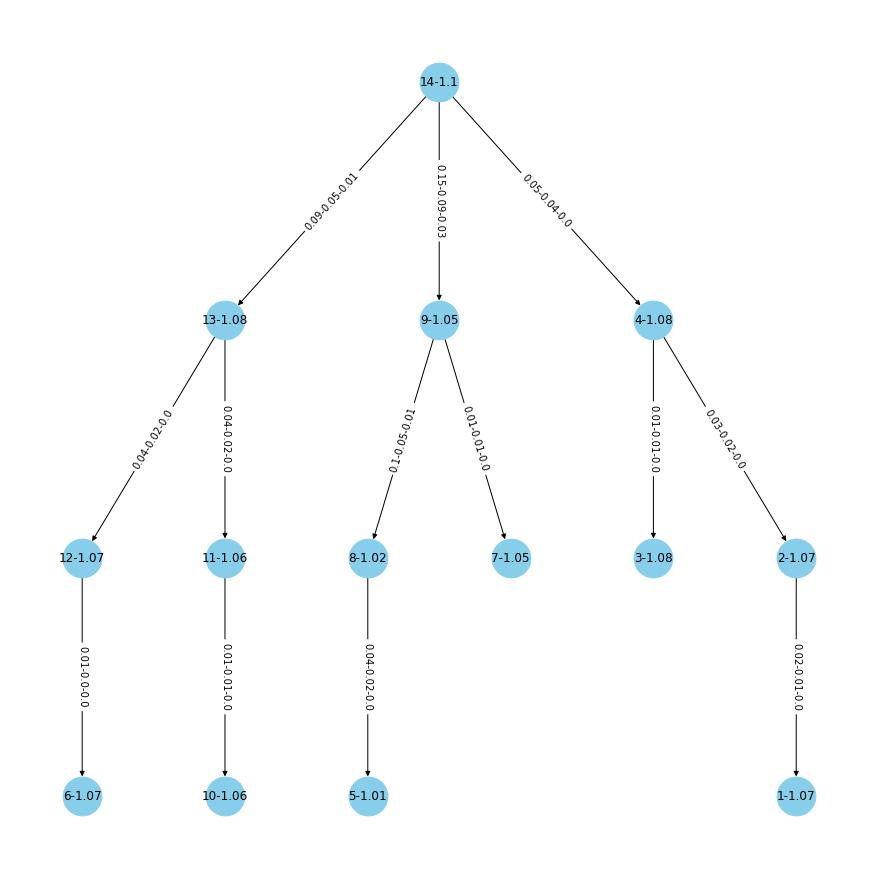

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

active_edges = [edge for edge in E if m.getVarByName(f'y[{edge[0]},{edge[1]}]').X == 1]
G.add_nodes_from(N)
G.add_edges_from(active_edges)

pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
plt.figure(3,figsize=(12,12)) 
nx.draw(G, node_size=1500, node_color="skyblue", pos=pos)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={edge: str(round(m.getVarByName(f'P[{edge[0]},{edge[1]}]').X,2)) +"-"+ str(round(m.getVarByName(f'Q[{edge[0]},{edge[1]}]').X,2)) + "-" + str(round(m.getVarByName(f'I[{edge[0]},{edge[1]}]').X,2)) for edge in active_edges}
)
nx.draw_networkx_labels(G, pos, {node: str(node) + "-" + str(round(m.getVarByName(f'V[{node}]').X, 2)) for node in N})
plt.show()

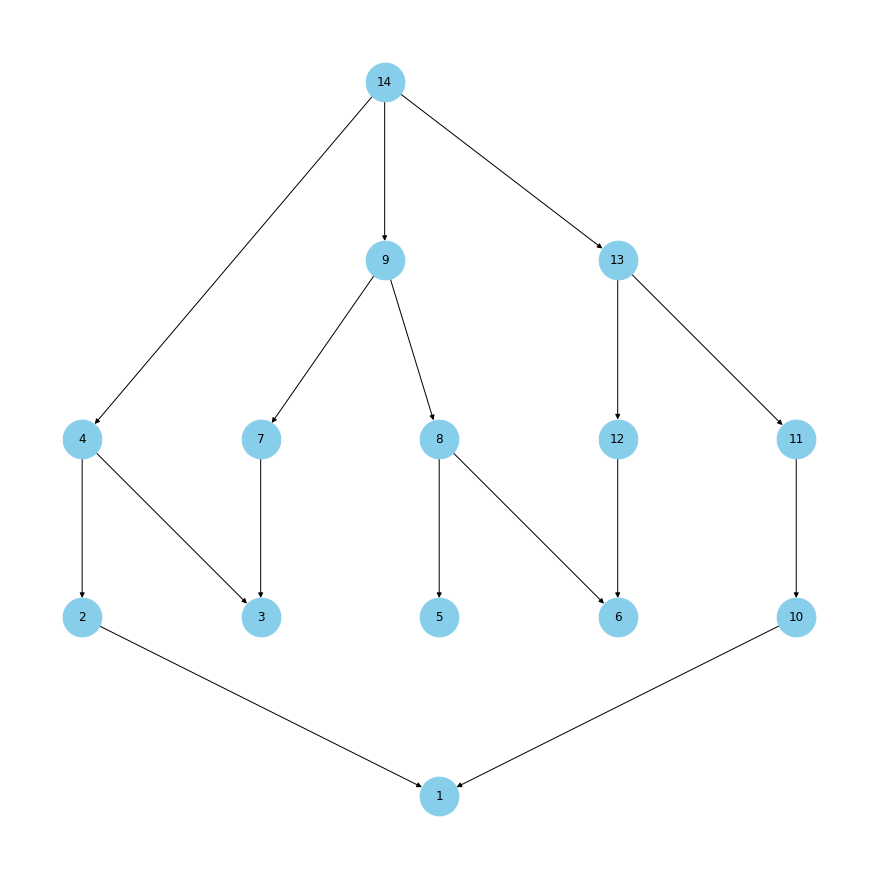

In [15]:
G = nx.DiGraph()

G.add_nodes_from(N)
G.add_edges_from(E)

pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
plt.figure(3,figsize=(12,12)) 
nx.draw(G, node_size=1500, node_color="skyblue", pos=pos)
nx.draw_networkx_labels(G, pos, {node: str(node) for node in N})
plt.show()

In [13]:
!conda install -c conda-forge pygraphviz

^C


In [18]:
obj = m.getObjective()
print(obj.getValue())

0.0055184952731569745
